# Process the deep mutational scanning data

This notebook is a modified version of `process_data.ipynb` from the [Bloom lab's escape calculator](https://github.com/jbloomlab/SARS2-RBD-escape-calc).

The data come from [this paper from Yunlong Cao's group](https://www.nature.com/articles/s41586-022-05644-7).

## Import Python modules

In [1]:
import os
import sys
import glob
from collections import defaultdict
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

resultsdir = '../results/processed_input_data/'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

## Process the data

Read in DMS data and antibody metadata, and filter out antibodies that do not have strong signal in the DMS experiment

In [2]:
# Read antibody metadata, which is in multiple sheets
imprinted_2022_raw_info = pd.read_excel(
    "../convergent_RBD_evolution/antibody_info.xlsx",
    header=1,
    sheet_name=None,
    usecols=lambda c: not c.startswith("Unnamed"),
)

common_cols = None

for sheetname, sheet in imprinted_2022_raw_info.items():
    columns = sheet.columns.tolist()
    if common_cols is None:
        common_cols = columns
    else:
        common_cols = [
            c for c in columns if c in set(common_cols).intersection(columns)
        ]

imprinted_2022_info = pd.concat(
    [
        sheet[common_cols].assign(sheet_name=sheet_name)
        for sheet_name, sheet in imprinted_2022_raw_info.items()
    ],
    ignore_index=True,
).rename(columns={"Antibody  Name": "antibody"}).assign(study="imprinted_2022")

assert len(imprinted_2022_info) == imprinted_2022_info["antibody"].nunique()
print('N antibodies with data:', len(imprinted_2022_info))

# Read in amino-acid level DMS data from Cao et al.
dms_df = pd.read_csv('../convergent_RBD_evolution/use_res_clean.csv')

# Make a list of antibodies with DMS data that shows strong signal of escape
# (i.e., maximum sum of escape scores per site is >2 for at least one site)
site_max_df = (
    dms_df
    .groupby(['antibody', 'site'], as_index=False)['mut_escape'].sum()
    .groupby('antibody', as_index=False)['mut_escape'].max()
)
abs_with_high_site_escape_scores = site_max_df[site_max_df['mut_escape'] > 2]['antibody'].unique()
print('N antibodies with strong DMS signal:', len(abs_with_high_site_escape_scores))

# Filter out antibodies that do not show strong signal from DMS
imprinted_2022_info = imprinted_2022_info[
    imprinted_2022_info['antibody'].isin(abs_with_high_site_escape_scores)
]
assert len(imprinted_2022_info) == len(abs_with_high_site_escape_scores)

imprinted_2022_info.head()

N antibodies with data: 3333
N antibodies with strong DMS signal: 2326


,antibody,source,D614G,BA.1,BA.2,BA.5,BA.2.75,BQ.1.1,XBB,Heavy chain V gene,Heavy chain J gene,Light chain V gene,Light chain J gene,Heavy chain AA,Light chain AA,sheet_name,study
0,BD-196,WT convalescents,1.93,>10,>10,>10,>10,>10,>10,IGHV1-3,IGHJ6,IGKV2-58,IGKJ1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,cross,imprinted_2022
3,BD-254,WT convalescents,0.25,>10,>10,>10,>10,>10,>10,IGHV3-23,IGHJ4,IGLV7-46,IGLJ2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...,cross,imprinted_2022
5,BD-319,WT convalescents,0.137,>10,>10,>10,>10,>10,>10,IGHV3-53,IGHJ3,IGLV2-23,IGLJ3,EVQLVESGGGLIQPGGSLRLSCAASGFTVSSNYMSWVRQAPGKGLE...,QSALTQPASVSGSPGQSITISCTGTSSDVGSYNLVSWYQQHPGKAP...,cross,imprinted_2022
6,BD-320,WT convalescents,2.49,2.48,3.17,2.82,3.34,1.79,1.69,IGHV4-59,IGHJ4,IGLV6-57,IGLJ3,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,NFMLTQPHSVSESPGKTVTISCTGSSGSIASNYVQWYQQRPGSAPT...,cross,imprinted_2022
7,BD-362,WT convalescents,0.212,>10,>10,>10,>10,>10,>10,IGHV1-18,IGHJ5,IGKV3-15,IGKJ5,QIQLVQSGAEVKKPGASVRVSCKASGFTFGRYGITWVRQVPGQGLE...,EIVMTQSPATLSVSPGERVTLSCRASQSVNRNLAWYQQKPGQAPRL...,cross,imprinted_2022


Get the antibody sources, and filter out antibodies isolated from SARS convalescents and from the WT-engineered group.

In [3]:
imprinted_2022_source = (
    imprinted_2022_info
    [["antibody", "source", "study"]]
    .query("source != 'WT-engineered'")
    .query("source != 'SARS convalescents'")
)
source_filtered_abs = imprinted_2022_source['antibody'].unique()
print('N antibodies after filtering based on source:', len(source_filtered_abs))
display(
    imprinted_2022_source
    .groupby(["study", "source"])
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
)

N antibodies after filtering based on source: 1616


n_antibodies
study          source                          
imprinted_2022 BA.1 convalescents           465
               BA.2 convalescents           472
               BA.5 convalescents           145
               WT convalescents             326
               WT vaccinees                 208

Get the IC50s for the above antibodies, and filter out the few antibodies with missing data against at least one viral variant

In [4]:
imprinted_2022_ic50s = (
    imprinted_2022_info
    .query("antibody in @source_filtered_abs")
    .melt(
        id_vars=["study", "antibody"],
        value_vars=["D614G", "BA.1", "BA.2", "BA.5", "BA.2.75", "BQ.1.1", "XBB"],
        var_name="virus",
        value_name="IC50",
    )
    # values of >10 to 10
    .query("IC50 != '--'")
    .assign(IC50=lambda x: x["IC50"].map(lambda ic50: 10 if ic50 == ">10" else float(ic50)))
)

print("\nNumber of IC50s per antibody:")
display(
    imprinted_2022_ic50s
    .groupby("antibody", as_index=False)
    .aggregate(viruses_w_IC50s=pd.NamedAgg("virus", lambda s: "; ".join(s)))
    .groupby("viruses_w_IC50s")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)

data = imprinted_2022_ic50s['antibody'].value_counts().reset_index()
ic50_filtered_abs = data[data['antibody'] == 7]['index'].unique()


Number of IC50s per antibody:


,n_antibodies
viruses_w_IC50s,
D614G; BA.1; BA.2; BA.5; BA.2.75; BQ.1.1; XBB,1603
D614G; BA.1; BA.2; BA.5; BA.2.75,6
D614G; BA.1; BA.2; BA.5; BA.2.75; BQ.1.1,3
D614G; BA.1; BA.2; BA.5; BA.2.75; XBB,3
BQ.1.1; XBB,1


In [5]:
print("\nNumber of antibodies with no neutralization on any retained virus:")
assert imprinted_2022_ic50s["IC50"].dtype == float
assert (imprinted_2022_ic50s["IC50"] <= 10).all()
display(
    imprinted_2022_ic50s
    .assign(non_neut=lambda x: x["IC50"] == 10)
    .groupby("antibody", as_index=False)
    .aggregate({"non_neut": "all"})
    .groupby("non_neut")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_index(ascending=False)
)


Number of antibodies with no neutralization on any retained virus:


,n_antibodies
non_neut,
True,439
False,1177


Get binding reactivities

In [6]:
# get the binding reactivities
imprinted_2022_binding = (
    imprinted_2022_info
    .query("antibody in @source_filtered_abs")
    .assign(
        binds=lambda x: x["sheet_name"].map(
            {
                "cross": ["Wuhan-Hu-1", "Omicron BA.2/BA.5"],
                "specific": ["Omicron BA.2/BA.5"],
            }
        )
    )
    [["study", "antibody", "binds"]]
    .explode("binds")
)

print("\nBinding targets per antibody:")
display(
    imprinted_2022_binding
    .groupby("antibody", as_index=False)
    .aggregate(binds=pd.NamedAgg("binds", lambda s: "; ".join(s)))
    .groupby("binds")
    .aggregate(n_antibodies=pd.NamedAgg("antibody", "nunique"))
    .sort_values("n_antibodies", ascending=False)
)


Binding targets per antibody:


,n_antibodies
binds,
Wuhan-Hu-1; Omicron BA.2/BA.5,1616


Make a list of antibodies passing all filters, then save the list to an output file

In [7]:
# Make a list of antibodies passing all filters
abs_passing_filters = list(set.intersection(
    set(abs_with_high_site_escape_scores),
    set(source_filtered_abs),
    set(ic50_filtered_abs)
))
print('N antibodies passing all filters', len(abs_passing_filters))

output_f = os.path.join(resultsdir, 'abs_passing_filters.txt')
with open(output_f, 'w') as f:
    for ab in abs_passing_filters:
        f.write(f'{ab}\n')

N antibodies passing all filters 1603


Now read the raw DMS data with escape scores at the level of amino-acid mutations, and then use these data to compute escape scores at the level of sites.

In [7]:
imprinted_2022_escape = (
    dms_df
    .query("antibody in @abs_passing_filters")
    .groupby(["antibody", "site"], as_index=False)
    .aggregate(escape=pd.NamedAgg("mut_escape", "sum"))
    .assign(study="imprinted_2022")
    .assign(
        normalized_escape=lambda x: (
            x["escape"] / x.groupby(["antibody", "study"])["escape"].transform("max")
        )
    )
)

imprinted_2022_escape

N antibodies passing all filters 1603


,antibody,site,escape,study,normalized_escape
0,1-57,338,0.521154,imprinted_2022,0.060839
1,1-57,359,0.140217,imprinted_2022,0.016369
2,1-57,370,0.285110,imprinted_2022,0.033284
3,1-57,394,0.112732,imprinted_2022,0.013160
4,1-57,396,0.194379,imprinted_2022,0.022692
...,...,...,...,...,...
33256,XGv-422,465,0.769640,imprinted_2022,0.229740
33257,XGv-422,466,0.886558,imprinted_2022,0.264641
33258,XGv-422,468,0.313522,imprinted_2022,0.093587
33259,XGv-422,484,0.165163,imprinted_2022,0.049302


Show the number of sites per antibody DMS that pass a given escape-score threshold. We do not filter on this since there aren't many antibodies that would be filtered out (using the Bloom lab threshold filtering out antibodies with >40 sites in the below plot)

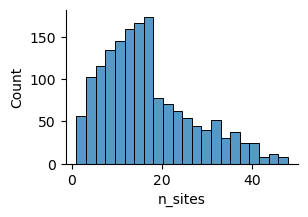

In [8]:
sig_escape_threshold = 0.1
n_sig_escape = (
    imprinted_2022_escape
    .query("escape >= @sig_escape_threshold")
    .groupby(["antibody", "study"], as_index=False)
    .aggregate(n_sites=pd.NamedAgg("site", "nunique"))
)
plt.figure(figsize=[3,2])
sns.histplot(x='n_sites', data=n_sig_escape)
sns.despine()
plt.show()

Save curated data to output files, only for antibodies that passed the above filters

In [9]:
# Save site-level escape scores
imprinted_2022_escape[
    imprinted_2022_escape['antibody'].isin(abs_passing_filters)
].to_csv(os.path.join(resultsdir, 'escape.csv'), index=False)

# Save data on antibody sources
imprinted_2022_source[
    imprinted_2022_source['antibody'].isin(abs_passing_filters)
].to_csv(os.path.join(resultsdir, 'antibody_sources.csv'), index=False)

# Save data on IC50s
imprinted_2022_ic50s[
    imprinted_2022_ic50s['antibody'].isin(abs_passing_filters)
].to_csv(os.path.join(resultsdir, 'antibody_IC50s.csv'), index=False)

Analyze the distribution of site-escape scores

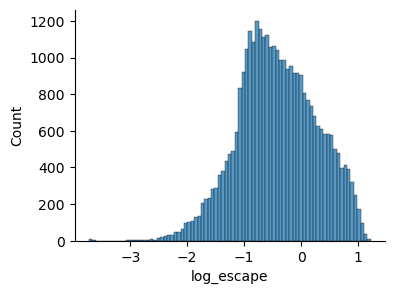

In [15]:
data = imprinted_2022_escape.copy()
data['log_escape'] = np.log10(data['escape'])
plt.figure(figsize=[4,3])
sns.histplot(x='log_escape', data=data)
sns.despine()
plt.show()